In [1]:
import numpy as np
import polars as pl

In [2]:
num_rows = 5000
rng = np.random.default_rng(seed=7)

In [3]:
buildings_data = {
    "sqft": rng.exponential(scale=1000, size=num_rows),
    "year": rng.integers(low=1995, high=2023, size=num_rows),
    "building_type": rng.choice(["A", "B", "C"], size=num_rows),
}
buildings = pl.DataFrame(buildings_data)
buildings

shape: (5_000, 3)
┌─────────────┬──────┬───────────────┐
│ sqft        ┆ year ┆ building_type │
│ ---         ┆ ---  ┆ ---           │
│ f64         ┆ i64  ┆ str           │
╞═════════════╪══════╪═══════════════╡
│ 707.529256  ┆ 1996 ┆ C             │
│ 1025.203348 ┆ 2020 ┆ C             │
│ 568.548657  ┆ 2012 ┆ A             │
│ 895.109864  ┆ 2000 ┆ A             │
│ …           ┆ …    ┆ …             │
│ 408.872783  ┆ 2009 ┆ C             │
│ 57.562059   ┆ 2019 ┆ C             │
│ 3728.088949 ┆ 2020 ┆ C             │
│ 686.678345  ┆ 2011 ┆ C             │
└─────────────┴──────┴───────────────┘

In [4]:
buildings.schema

{'sqft': Float64, 'year': Int64, 'building_type': Utf8}

In [7]:
buildings.shape

(5000, 3)

In [8]:
buildings.describe()

shape: (9, 4)
┌────────────┬─────────────┬───────────┬───────────────┐
│ describe   ┆ sqft        ┆ year      ┆ building_type │
│ ---        ┆ ---         ┆ ---       ┆ ---           │
│ str        ┆ f64         ┆ f64       ┆ str           │
╞════════════╪═════════════╪═══════════╪═══════════════╡
│ count      ┆ 5000.0      ┆ 5000.0    ┆ 5000          │
│ null_count ┆ 0.0         ┆ 0.0       ┆ 0             │
│ mean       ┆ 994.094456  ┆ 2008.5258 ┆ null          │
│ std        ┆ 1016.641569 ┆ 8.062353  ┆ null          │
│ min        ┆ 1.133256    ┆ 1995.0    ┆ A             │
│ 25%        ┆ 286.807549  ┆ 2001.0    ┆ null          │
│ 50%        ┆ 669.406964  ┆ 2009.0    ┆ null          │
│ 75%        ┆ 1343.539279 ┆ 2015.0    ┆ null          │
│ max        ┆ 9307.793917 ┆ 2022.0    ┆ C             │
└────────────┴─────────────┴───────────┴───────────────┘

In [9]:
buildings.glimpse()  # type: ignore

Rows: 5000
Columns: 3
$ sqft          <f64> 707.5292557919215, 1025.203348294905, 568.5486573832515, 895.1098635951629, 206.53275401650552, 3383.6373514362535, 9.75362664875075, 2809.2157631107834, 575.3327563498636, 300.53401255485437
$ year          <i64> 1996, 2020, 2012, 2000, 2011, 2018, 2007, 2004, 2021, 2003
$ building_type <str> C, C, A, A, A, B, A, B, A, A



In [23]:
buildings.select("sqft")

shape: (5_000, 1)
┌─────────────┐
│ sqft        │
│ ---         │
│ f64         │
╞═════════════╡
│ 707.529256  │
│ 1025.203348 │
│ 568.548657  │
│ 895.109864  │
│ …           │
│ 408.872783  │
│ 57.562059   │
│ 3728.088949 │
│ 686.678345  │
└─────────────┘

In [24]:
buildings.select(pl.col("sqft"))

shape: (5_000, 1)
┌─────────────┐
│ sqft        │
│ ---         │
│ f64         │
╞═════════════╡
│ 707.529256  │
│ 1025.203348 │
│ 568.548657  │
│ 895.109864  │
│ …           │
│ 408.872783  │
│ 57.562059   │
│ 3728.088949 │
│ 686.678345  │
└─────────────┘

In [26]:
buildings.select(pl.col("sqft").sort() / 1_000).rename({"sqft": "thousand_sqft"})

shape: (5_000, 1)
┌───────────────┐
│ thousand_sqft │
│ ---           │
│ f64           │
╞═══════════════╡
│ 0.001133      │
│ 0.001152      │
│ 0.001429      │
│ 0.001439      │
│ …             │
│ 7.247539      │
│ 7.629569      │
│ 8.313942      │
│ 9.307794      │
└───────────────┘

In [27]:
after_2015 = buildings.filter(pl.col("year") > 2015)
after_2015.shape

(1230, 3)

In [11]:
buildings.group_by("year").agg(pl.count()).sort("year")

shape: (28, 2)
┌──────┬───────┐
│ year ┆ count │
│ ---  ┆ ---   │
│ i64  ┆ u32   │
╞══════╪═══════╡
│ 1995 ┆ 176   │
│ 1996 ┆ 178   │
│ 1997 ┆ 175   │
│ 1998 ┆ 176   │
│ …    ┆ …     │
│ 2019 ┆ 175   │
│ 2020 ┆ 180   │
│ 2021 ┆ 180   │
│ 2022 ┆ 179   │
└──────┴───────┘

In [30]:
(
    buildings.group_by("building_type")
    .agg(
        [
            pl.count().alias("records"),
            pl.mean("sqft").suffix("_mean"),
            pl.min("sqft").suffix("_min"),
            pl.max("sqft").suffix("_max"),
            pl.mean("year").suffix("mean"),
            pl.min("year").suffix("_min"),
            pl.max("year").suffix("_max"),
        ]
    )
    .sort("building_type")
)

shape: (3, 8)
┌──────────────┬─────────┬────────────┬──────────┬─────────────┬─────────────┬──────────┬──────────┐
│ building_typ ┆ records ┆ sqft_mean  ┆ sqft_min ┆ sqft_max    ┆ yearmean    ┆ year_min ┆ year_max │
│ e            ┆ ---     ┆ ---        ┆ ---      ┆ ---         ┆ ---         ┆ ---      ┆ ---      │
│ ---          ┆ u32     ┆ f64        ┆ f64      ┆ f64         ┆ f64         ┆ i64      ┆ i64      │
│ str          ┆         ┆            ┆          ┆             ┆             ┆          ┆          │
╞══════════════╪═════════╪════════════╪══════════╪═════════════╪═════════════╪══════════╪══════════╡
│ A            ┆ 1653    ┆ 989.539918 ┆ 1.152109 ┆ 7247.538867 ┆ 2008.766485 ┆ 1995     ┆ 2022     │
│ B            ┆ 1655    ┆ 992.754444 ┆ 1.133256 ┆ 8313.942444 ┆ 2008.36435  ┆ 1995     ┆ 2022     │
│ C            ┆ 1692    ┆ 999.854722 ┆ 1.42909  ┆ 9307.793917 ┆ 2008.448582 ┆ 1995     ┆ 2022     │
└──────────────┴─────────┴────────────┴──────────┴─────────────┴─────────────┴──────────┴──────────┘

In [31]:
buildings = {
    "sqft": rng.exponential(scale=1000, size=num_rows),
    "price": rng.exponential(scale=100_000, size=num_rows),
    "year": rng.integers(low=1995, high=2023, size=num_rows),
    "building_type": rng.choice(["A", "B", "C"], size=num_rows),
}
buildings_lazy = pl.LazyFrame(buildings)
buildings_lazy

<LazyFrame [4 cols, {"sqft": Float64 … "building_type": Utf8}] at 0x7FCC9D1DAAD0>

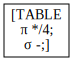

In [33]:
buildings_lazy.show_graph()

In [34]:
lazy_query = (
    buildings_lazy.with_columns(
        (pl.col("price") / pl.col("sqft")).alias("price_per_sqft")
    )
    .filter(pl.col("price_per_sqft") > 100)
    .filter(pl.col("year") < 2010)
)
lazy_query

<LazyFrame [5 cols, {"sqft": Float64 … "price_per_sqft": Float64}] at 0x7FCD301A6990>

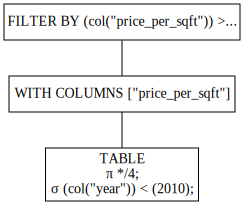

In [35]:
lazy_query.show_graph()

In [37]:
print(lazy_query.explain())

FILTER [(col("price_per_sqft")) > (100.0)] FROM
 WITH_COLUMNS:
 [[(col("price")) / (col("sqft"))].alias("price_per_sqft")]
  DF ["sqft", "price", "year", "building_type"]; PROJECT */4 COLUMNS; SELECTION: "[(col(\"year\")) < (2010)]"


In [44]:
(
    lazy_query.collect()
    .select(pl.col(["year", "price_per_sqft"]))
    .sort(["year", "price_per_sqft"])
)

shape: (1_338, 2)
┌──────┬────────────────┐
│ year ┆ price_per_sqft │
│ ---  ┆ ---            │
│ i64  ┆ f64            │
╞══════╪════════════════╡
│ 1995 ┆ 102.506649     │
│ 1995 ┆ 112.917276     │
│ 1995 ┆ 118.504509     │
│ 1995 ┆ 118.866006     │
│ …    ┆ …              │
│ 2009 ┆ 8597.329357    │
│ 2009 ┆ 11098.672627   │
│ 2009 ┆ 11169.849181   │
│ 2009 ┆ 11579.856048   │
└──────┴────────────────┘

In [45]:
import pathlib

local_file_path = pathlib.Path("electric_cars.csv")

lazy_car_data = pl.scan_csv(local_file_path)

lazy_car_data

<LazyFrame [17 cols, {"VIN (1-10)": Utf8 … "2020 Census Tract": Int64}] at 0x7FCC9D1D8A50>

In [46]:
lazy_car_data.schema

{'VIN (1-10)': Utf8,
 'County': Utf8,
 'City': Utf8,
 'State': Utf8,
 'Postal Code': Int64,
 'Model Year': Int64,
 'Make': Utf8,
 'Model': Utf8,
 'Electric Vehicle Type': Utf8,
 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': Utf8,
 'Electric Range': Int64,
 'Base MSRP': Int64,
 'Legislative District': Int64,
 'DOL Vehicle ID': Int64,
 'Vehicle Location': Utf8,
 'Electric Utility': Utf8,
 '2020 Census Tract': Int64}

In [49]:
lazy_car_query = (
    lazy_car_data.filter((pl.col("Model Year") >= 2018))
    .filter(pl.col("Electric Vehicle Type") == "Battery Electric Vehicle (BEV)")
    .group_by(["State", "Make"])
    .agg(
        pl.mean("Electric Range").alias("Average Electric Range"),
        pl.min("Model Year").alias("Oldest Model Year"),
        pl.count().alias("Number of Cars"),
    )
    .filter(pl.col("Average Electric Range") > 0)
    .filter(pl.col("Number of Cars") > 5)
    .sort(pl.col("Number of Cars"), descending=True)
)

lazy_car_query

<LazyFrame [5 cols, {"State": Utf8 … "Number of Cars": UInt32}] at 0x7FCC7F2A5010>

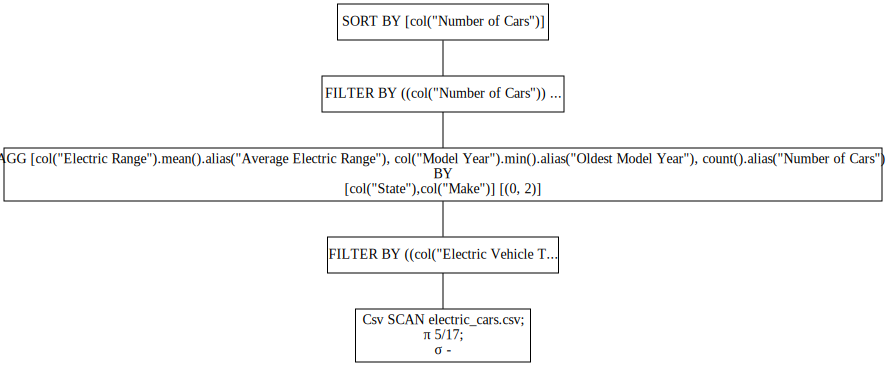

In [50]:
lazy_car_query.show_graph()

In [51]:
lazy_car_query.collect()

shape: (21, 5)
┌───────┬───────────┬────────────────────────┬───────────────────┬────────────────┐
│ State ┆ Make      ┆ Average Electric Range ┆ Oldest Model Year ┆ Number of Cars │
│ ---   ┆ ---       ┆ ---                    ┆ ---               ┆ ---            │
│ str   ┆ str       ┆ f64                    ┆ i64               ┆ u32            │
╞═══════╪═══════════╪════════════════════════╪═══════════════════╪════════════════╡
│ WA    ┆ TESLA     ┆ 82.992376              ┆ 2018              ┆ 59417          │
│ WA    ┆ NISSAN    ┆ 90.371814              ┆ 2018              ┆ 5492           │
│ WA    ┆ CHEVROLET ┆ 106.520663             ┆ 2018              ┆ 5372           │
│ WA    ┆ KIA       ┆ 61.017004              ┆ 2018              ┆ 3411           │
│ …     ┆ …         ┆ …                      ┆ …                 ┆ …              │
│ NC    ┆ TESLA     ┆ 47.777778              ┆ 2018              ┆ 9              │
│ MD    ┆ TESLA     ┆ 56.222222              ┆ 2018              ┆ 9              │
│ TX    ┆ TESLA     ┆ 94.625                 ┆ 2018              ┆ 8              │
│ IL    ┆ TESLA     ┆ 162.0                  ┆ 2018              ┆ 6              │
└───────┴───────────┴────────────────────────┴───────────────────┴────────────────┘

In [52]:
data = pl.DataFrame(
    {
        "A": [1, 2, 3, 4, 5],
        "B": [6, 7, 8, 9, 10],
    }
)

data.write_csv("data.csv")
data.write_ndjson("data.json")
data.write_parquet("data.parquet")

In [53]:
data_csv = pl.read_csv("data.csv")
data_csv_lazy = pl.scan_csv("data.csv")
data_csv_lazy.schema

{'A': Int64, 'B': Int64}

In [54]:
data_json = pl.read_ndjson("data.json")
data_json_lazy = pl.scan_ndjson("data.json")
data_json_lazy.schema

{'A': Int64, 'B': Int64}

In [55]:
data_parquet = pl.read_parquet("data.parquet")
data_parquet_lazy = pl.scan_parquet("data.parquet")
data_parquet_lazy.schema

{'A': Int64, 'B': Int64}

In [56]:
import pandas as pd

In [57]:
pandas_data = pd.DataFrame({"A": [1, 2, 3, 4, 5], "B": [6, 7, 8, 9, 10]})

numpy_data = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]).T

In [58]:
pandas_data

A   B
0  1   6
1  2   7
2  3   8
3  4   9
4  5  10

In [59]:
numpy_data

array([[ 1,  6],
       [ 2,  7],
       [ 3,  8],
       [ 4,  9],
       [ 5, 10]])

In [60]:
pl.from_pandas(pandas_data)

shape: (5, 2)
┌─────┬─────┐
│ A   ┆ B   │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ 1   ┆ 6   │
│ 2   ┆ 7   │
│ 3   ┆ 8   │
│ 4   ┆ 9   │
│ 5   ┆ 10  │
└─────┴─────┘

In [61]:
pl.from_numpy(numpy_data, schema={"A": pl.Int64, "B": pl.Int64})

shape: (5, 2)
┌─────┬─────┐
│ A   ┆ B   │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ 1   ┆ 6   │
│ 2   ┆ 7   │
│ 3   ┆ 8   │
│ 4   ┆ 9   │
│ 5   ┆ 10  │
└─────┴─────┘

In [62]:
cars = lazy_car_query.collect()

In [63]:
cars.to_pandas()

State        Make  Average Electric Range  Oldest Model Year  \
0     WA       TESLA               82.992376               2018   
1     WA      NISSAN               90.371814               2018   
2     WA   CHEVROLET              106.520663               2018   
3     WA         KIA               61.017004               2018   
4     WA  VOLKSWAGEN               20.735121               2018   
5     WA        FORD                0.089472               2018   
6     WA     HYUNDAI               24.501675               2018   
7     WA        AUDI               84.094508               2019   
8     WA         BMW               20.270769               2018   
9     WA        MINI               24.574468               2021   
10    WA     PORSCHE               78.053950               2020   
11    WA    POLESTAR               55.862705               2021   
12    WA      JAGUAR              205.281818               2019   
13    WA        FIAT               84.000000               2018   
14    WA       SMART               58.000000               2018   
15    CA       TESLA               95.454545               2018   
16    VA       TESLA              114.692308               2018   
17    NC       TESLA               47.777778               2018   
18    MD       TESLA               56.222222               2018   
19    TX       TESLA               94.625000               2018   
20    IL       TESLA              162.000000               2018   

    Number of Cars  
0            59417  
1             5492  
2             5372  
3             3411  
4             3394  
5             3353  
6             2388  
7             1566  
8             1300  
9              564  
10             519  
11             488  
12             220  
13              68  
14              55  
15              44  
16              13  
17               9  
18               9  
19               8  
20               6

In [64]:
cars.to_numpy()

array([['WA', 'TESLA', 82.99237591934968, 2018, 59417],
       ['WA', 'NISSAN', 90.37181354697742, 2018, 5492],
       ['WA', 'CHEVROLET', 106.52066269545793, 2018, 5372],
       ['WA', 'KIA', 61.01700381119906, 2018, 3411],
       ['WA', 'VOLKSWAGEN', 20.73512080141426, 2018, 3394],
       ['WA', 'FORD', 0.08947211452430659, 2018, 3353],
       ['WA', 'HYUNDAI', 24.501675041876048, 2018, 2388],
       ['WA', 'AUDI', 84.09450830140486, 2019, 1566],
       ['WA', 'BMW', 20.27076923076923, 2018, 1300],
       ['WA', 'MINI', 24.574468085106382, 2021, 564],
       ['WA', 'PORSCHE', 78.0539499036609, 2020, 519],
       ['WA', 'POLESTAR', 55.86270491803279, 2021, 488],
       ['WA', 'JAGUAR', 205.28181818181818, 2019, 220],
       ['WA', 'FIAT', 84.0, 2018, 68],
       ['WA', 'SMART', 58.0, 2018, 55],
       ['CA', 'TESLA', 95.45454545454545, 2018, 44],
       ['VA', 'TESLA', 114.6923076923077, 2018, 13],
       ['NC', 'TESLA', 47.77777777777778, 2018, 9],
       ['MD', 'TESLA', 56.222222222